In [1]:
# Credit, using some code from https://pageperso.lis-lab.fr/benoit.favre/pstaln/09_embedding_evaluation.html
# Credit, using data / setup from Assignment 3, Professor Greg Durrett's Masters CS 388 Course 

from a3distrib.treedata import *
from transformers import AutoModel, AutoTokenizer
import numpy as np
from modmask_bert_models import *

2022-09-05 04:56:19.986821: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-05 04:56:19.986842: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train_sents = read_labeled_sents('./a3distrib/data/train_sents.conll')
dev_sents = read_labeled_sents('./a3distrib/data/dev_sents.conll')

Read 39832 sents from ./a3distrib/data/train_sents.conll
Read 1700 sents from ./a3distrib/data/dev_sents.conll


In [3]:
alltags = []
for t in train_sents:
    alltags.extend(t.get_tags())

In [4]:
train_words = [t.get_words() for t in train_sents]
train_tags = [t.get_tags() for t in train_sents]
dev_words = [t.get_words() for t in dev_sents]
dev_tags = [t.get_tags() for t in dev_sents]

In [5]:
# use a defaultdict to count the number of occurrences of each tag
import collections
tagset = collections.defaultdict(int)

for tagging in alltags:
    for tag in tagging:
        tagset[tag] += 1

print('number of different tags:', len(tagset))

# print count and tag sorted by decreasing count
for tag, count in sorted(tagset.items(), reverse=True, key=lambda x: x[1]):
  print(count, tag)
    
# Found 30 tags in train set

number of different tags: 30
692438 N
172580 P
162766 D
160692 B
132804 J
125360 V
108863 T
98554 I
84462 C
73722 S
68843 R
48727 ,
39478 .
31058 O
21672 Z
15947 $
14846 G
14184 `
13838 '
9861 M
9202 W
4772 :
863 E
863 X
234 F
142 #
97 U
97 H
58 Y
36 L


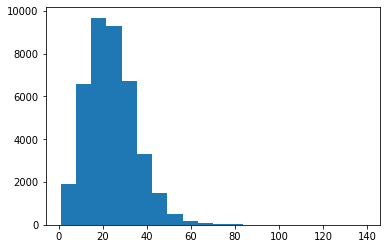

max length: 139


In [6]:
from matplotlib import pyplot as plt

# compute and show histogram for sentence length
plt.hist([len(sentence) for sentence in train_sents], 20)
plt.show()

# compute max sentence length
print('max length:', max([len(sentence) for sentence in train_sents]))

# Found smaller max length (this task is definetely on the easier side)

In [7]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [8]:
spaced_dset = [' '.join(t) for t in train_words]

In [9]:
bert_tokenized_sentence = tokenizer(spaced_dset, padding="max_length", max_length=500)

In [10]:
bert_tokenized_sentence[0]

Encoding(num_tokens=500, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [11]:
import re
def align_tokenizations(sentences, taggings):
    bert_tokenized_sentences = []
    aligned_taggings = []

    for sentence, tagging in zip(sentences, taggings):
        # first generate BERT-tokenization
        bert_tokenized_sentence = tokenizer.tokenize(' '.join(sentence))

        aligned_tagging = []
        current_word = ''
        index = 0 # index of current word in sentence and tagging
        for token in bert_tokenized_sentence:
            current_word += re.sub(r'^##', '', token) # recompose word with subtoken
            sentence[index] = sentence[index].replace('\xad', '') # fix bug in data

            # note that some word factors correspond to unknown words in BERT
            assert token == '[UNK]' or sentence[index].startswith(current_word)

            if token == '[UNK]' or sentence[index] == current_word: # if we completed a word
                current_word = ''
                aligned_tagging.append(tagging[index])
                index += 1
            else: # otherwise insert padding
                aligned_tagging.append(tagging[index])

        assert len(bert_tokenized_sentence) == len(aligned_tagging)

        bert_tokenized_sentences.append(bert_tokenized_sentence)
        aligned_taggings.append(aligned_tagging)

    return bert_tokenized_sentences, aligned_taggings

train_bert_tokenized_sentences, train_aligned_taggings = align_tokenizations(train_words, train_tags)
test_bert_tokenized_sentences, test_aligned_taggings = align_tokenizations(dev_words, dev_tags)

In [12]:
print(train_bert_tokenized_sentences[42])
print(train_aligned_taggings[42])

['Also', 'excluded', 'will', 'be', 'investments', 'in', 'companies', 'with', '`', '`', 'significant', "'", "'", 'business', 'stem', '##ming', 'from', 'weapons', 'manufacture', ',', 'alcoholic', 'beverages', 'or', 'tobacco', '.']
['RB', 'VBN', 'MD', 'VB', 'NNS', 'IN', 'NNS', 'IN', '``', '``', 'JJ', "''", "''", 'NN', 'VBG', 'VBG', 'IN', 'NNS', 'NN', ',', 'JJ', 'NNS', 'CC', 'NN', '.']


In [13]:
import torch
device = torch.device('cuda:2' if torch.cuda.is_available else 'cpu')

import collections

label_vocab = collections.defaultdict(lambda: len(label_vocab))
label_vocab['<pad>'] = 0
label_vocab['<cls>'] = 1
label_vocab['<sep>'] = 2


# do the BERT SEP CLS thing
def convert_to_ids(sentences, taggings):
    sentences_ids = []
    taggings_ids = []
    for sentence, tagging in zip(sentences, taggings):
        sentence_tensor = torch.tensor(tokenizer.convert_tokens_to_ids(['[CLS]'] + sentence + ['[SEP]'])).long()
        tagging_tensor = torch.tensor([1] + [label_vocab[tag] for tag in tagging] + [2]).long()

        sentences_ids.append(sentence_tensor.to(device))
        taggings_ids.append(tagging_tensor.to(device))
    return sentences_ids, taggings_ids

train_sentences_ids, train_taggings_ids = convert_to_ids(train_bert_tokenized_sentences, train_aligned_taggings)
test_sentences_ids, test_taggings_ids = convert_to_ids(test_bert_tokenized_sentences, test_aligned_taggings)


In [14]:
train_taggings_ids[4]

tensor([ 1,  5,  5,  5, 14,  7, 15, 25,  7,  7, 14, 16, 22, 20, 20, 20, 20,  7,
         3,  4,  7,  7,  7,  3,  5, 15,  5, 14, 15,  3, 25, 25, 12, 19,  2],
       device='cuda:2')

In [15]:
len(label_vocab)

46

In [16]:
import json 

with open("lab_vocab.json", "w") as outfile:
    json.dump(label_vocab, outfile)

In [44]:
from torch.utils.data import Dataset

class PosTaggingDataset(Dataset):
    def __init__(self, sentences, taggings):
        assert len(sentences) == len(taggings)
        self.sentences = sentences
        self.taggings = taggings

    def __getitem__(self, i):
        return self.sentences[i], self.taggings[i]

    def __len__(self):
        return len(self.sentences)

# function to create a batch from a list of instances
def collate_fn(items):
    max_len = max(len(item[0]) for item in items)

    sentences = torch.zeros((len(items), max_len), device=items[0][0].device).long().to(device)
    taggings = torch.zeros((len(items), max_len)).long().to(device)
    masks = torch.zeros((len(items), max_len, max_len), device=items[0][0].device).float().to(device)
    

    for i, (sentence, tagging) in enumerate(items):
        assert len(sentence)==len(tagging)
        sentences[i][0:len(sentence)] = sentence
        taggings[i][0:len(tagging)] = tagging
        masks[i][0:len(sentence)] = sentences[i].bool().int()
        
        # make mask upper-triangular
    masks = torch.triu(masks)
    #masks[masks==0] = -float('inf')

    return sentences, taggings, masks

x, y, m = collate_fn([[torch.tensor([1, 2, 3]), torch.tensor([4, 5, 6])], [torch.tensor([1, 2]), torch.tensor([3, 4])]])
print(x.shape, y.shape)

torch.Size([2, 3]) torch.Size([2, 3])


In [45]:
m

tensor([[[1., 1., 1.],
         [0., 1., 1.],
         [0., 0., 1.]],

        [[1., 1., 0.],
         [0., 1., 0.],
         [0., 0., 0.]]], device='cuda:2')

In [46]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(PosTaggingDataset(train_sentences_ids, train_taggings_ids), batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(PosTaggingDataset(test_sentences_ids, test_taggings_ids), batch_size=batch_size, collate_fn=collate_fn)

In [47]:
def perf(model, loader):
    criterion = nn.CrossEntropyLoss()
    model.eval() # do not apply training-specific steps such as dropout
    total_loss = correct = num_loss = num_perf = 0
    for x, y, m in loader:
        with torch.no_grad(): # no need to store computation graph for gradients
            # perform inference and compute loss
            y_scores = model(x, attmasks=m)
            loss = criterion(y_scores.view(-1, len(label_vocab)), y.view(-1)) # requires tensors of shape (num-instances, num-labels) and (num-instances)

            # gather loss statistics
            total_loss += loss.item()
            num_loss += 1

            # gather accuracy statistics
            y_pred = torch.max(y_scores, 2)[1] # compute highest-scoring tag
            mask = (y != 0) # ignore <pad> tags
            correct += torch.sum((y_pred == y) * mask) # compute number of correct predictions
            num_perf += torch.sum(mask).item()
    return total_loss / num_loss, correct.item() / num_perf

In [48]:
import torch.optim as optim

def fit(model, epochs, optimizer):
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, y, mask in train_loader:
            optimizer.zero_grad() # start accumulating gradients
            y_scores = model(x, attmasks=mask)
            loss = criterion(y_scores.view(-1, len(label_vocab)), y.view(-1))
            loss.backward() # compute gradients though computation graph
            optimizer.step() # modify model parameters
            total_loss += loss.item()
            num += 1
        print(1 + epoch, total_loss / num, *perf(model, test_loader))

In [49]:
import torch.nn as nn
from transformers import AutoConfig

class LinearProbeBert(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained('bert-base-cased')
        #self.bert = LatticeBertModel(AutoConfig.from_pretrained('bert-base-cased'))
        self.probe = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.to(device)

    def parameters(self):
        return self.probe.parameters()
  
    def forward(self, sentences, attmasks=None):
        #with torch.no_grad(): # no training of BERT parameters
        # yes train BERT parameters
        
        """
        for param in self.bert.embeddings.parameters():
            param.requires_grad = False
        for layer in self.bert.encoder.layer[:4]:
            for param in layer.parameters():
                param.requires_grad = False
        """
        
        assert attmasks is not None
        with torch.no_grad(): # no training of BERT parameters
            #word_rep, sentence_rep = self.bert(sentences, return_dict=False)
            word_rep, sentence_rep = self.bert(sentences, encoder_attention_mask=attmasks, attention_mask=attmasks, return_dict=False)
        return self.probe(word_rep)

In [32]:
import json 

with open("lab_vocab.json", "w") as outfile:
    json.dump(label_vocab, outfile)
#del bert_model

In [33]:
# the model should return a tensor of shape (batch size, sequence length, number of labels)
bert_model = LinearProbeBert(len(label_vocab))
#y = bert_model(torch.tensor([[0, 1, 2], [3, 4, 5]]).to(device))
#print(y.shape)
#bert_model.load_state_dict(torch.load("./ckpt/posbert.pth"))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [53]:
fit(bert_model, 20, optim.Adam(bert_model.parameters(), lr=1e-2))


KeyboardInterrupt



In [51]:
torch.save(bert_model.state_dict(), "./a3distrib/ckpt/posbert1way.pth")
#bert_model.load_state_dict(torch.load("./ckpt/posbert.pth"))
#fit(bert_model, 20)

In [ ]:
perf(bert_model, test_loader)

In [ ]:
torch.save(bert_model.state_dict(), "./posbertmodel/posbert.pth")

In [23]:
x, y, m = collate_fn(list(zip(test_sentences_ids, test_taggings_ids))[:10])

In [24]:
m[0][0]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:2')

In [ ]:
bert_model(x, attmasks=m)